# 03 Time series

In this notebook we use traditional time series approaches.

## Reading data

We read the datasets from the csv files.

In [43]:
# Basic packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Time series packages
import catboost
from catboost import CatBoostRegressor
from catboost import Pool

from sklearn.metrics import mean_squared_error

sales = pd.read_csv('data/sales_train.csv', parse_dates=['date'], dtype={
    'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32',
    'item_price': 'float32', 'item_cnt_day': 'int32'
})

test = pd.read_csv('data/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})

In [44]:
subset = False

if subset:
    shop_ids = [2, 7]
    item_ids = [4897, 7220]
    sales = sales.query('shop_id == @shop_ids and item_id == @item_ids')

In [45]:
# We keep only shops and items present in the test dataset
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

sales = sales[sales['shop_id'].isin(test_shop_ids)]
sales = sales[sales['item_id'].isin(test_item_ids)]

In [46]:
# Aggregate data per month
monthly_sales = sales.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
monthly_sales = monthly_sales.agg({'item_price': ['sum', 'mean'], 'item_cnt_day': ['sum', 'mean','count']})

# And rename the columns
monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [47]:
n_months = 34
date_block_nums = range(n_months)

shop_ids = monthly_sales['shop_id'].unique()

full_sales = []
for date_block_num in date_block_nums:
    for shop_id in shop_ids:
        shop_monthly_sales = monthly_sales[monthly_sales['shop_id'] == shop_id]

        item_ids = shop_monthly_sales['item_id'].unique()
        for item_id in item_ids:
            full_sales.append([date_block_num, shop_id, item_id])

full_sales = pd.DataFrame(full_sales, columns=['date_block_num', 'shop_id', 'item_id'])

,date_block_num,shop_id,item_id
0,0,2,33
1,0,2,482
2,0,2,491
3,0,2,839
4,0,2,1007
...,...,...,...
3787731,33,36,22001
3787732,33,36,22087
3787733,33,36,22088
3787734,33,36,22100


In [48]:
monthly_sales = pd.merge(full_sales, monthly_sales, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)

In [49]:
monthly_sales = monthly_sales.sort_values(by=['shop_id', 'item_id', 'date_block_num'])

In [50]:
monthly_sales['year'] = 2013 + monthly_sales['date_block_num'] // 12
monthly_sales['month'] = monthly_sales['date_block_num'] % 12

In [51]:
gp_month_mean = monthly_sales.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = monthly_sales.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_shop_mean = monthly_sales.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = monthly_sales.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

Text(0.5, 1.0, 'Montly sum')

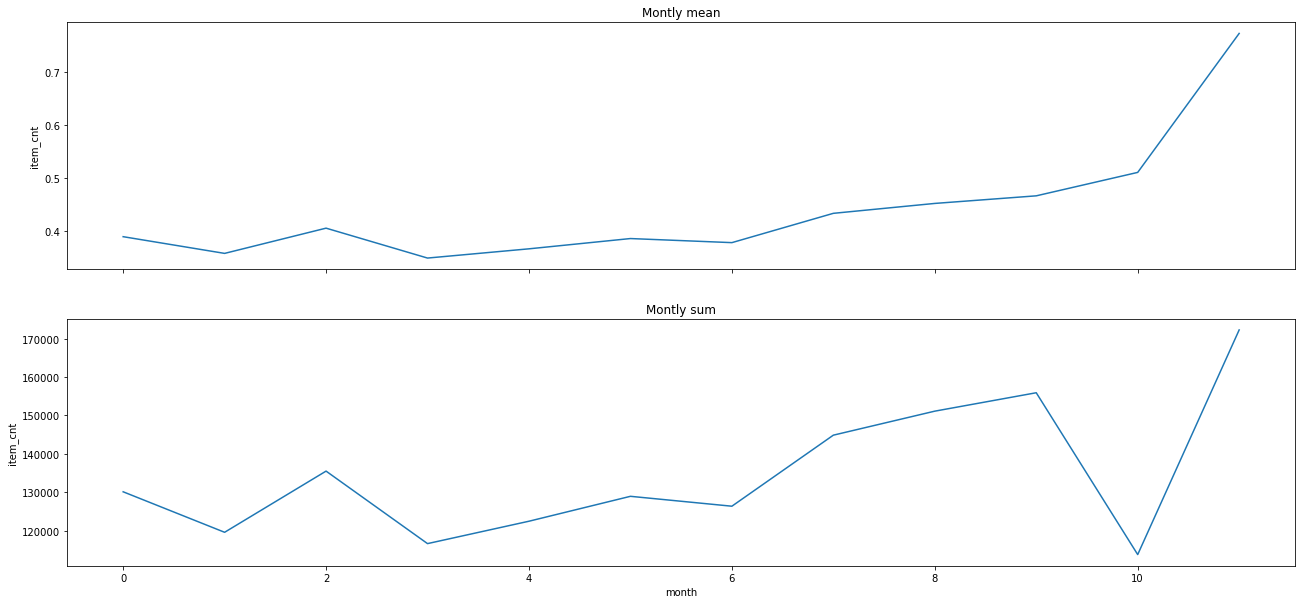

In [52]:
fig, axs = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axs[0]).set_title('Montly mean')
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axs[1]).set_title('Montly sum')

Text(0.5, 1.0, 'Montly sum')

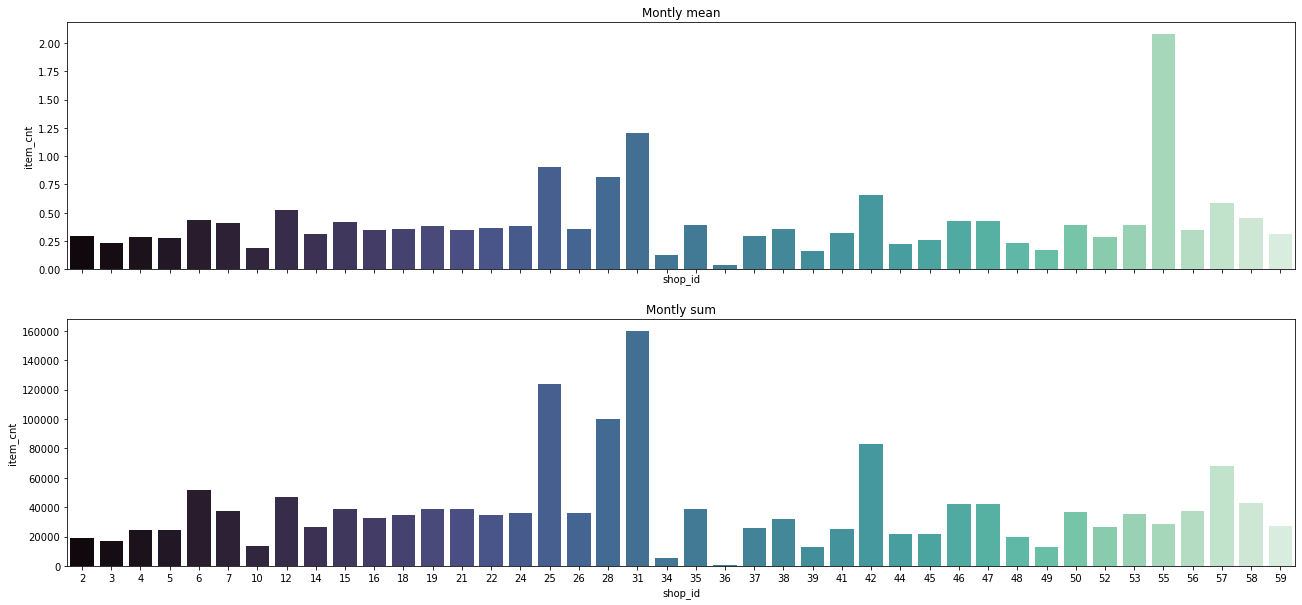

In [53]:
fig, axs = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axs[0], palette='mako').set_title('Montly mean')
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axs[1], palette='mako').set_title('Montly sum')

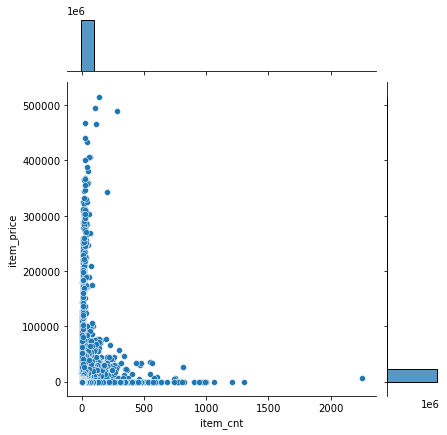

In [54]:
sns.jointplot(x='item_cnt', y='item_price', data=monthly_sales)

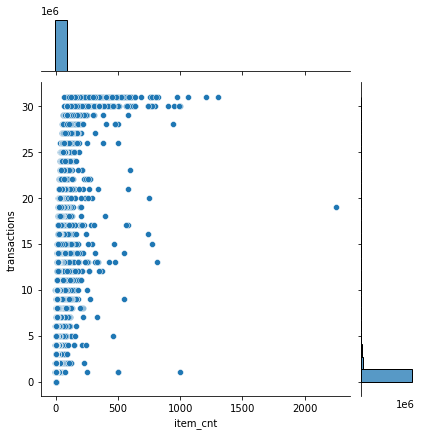

In [55]:
sns.jointplot(x='item_cnt', y='transactions', data=monthly_sales)

In [56]:
# Remove outliers
monthly_sales = monthly_sales[monthly_sales['item_cnt'] >= 0]
monthly_sales = monthly_sales[monthly_sales['item_cnt'] <= 20]
monthly_sales = monthly_sales[monthly_sales['item_price'] <= 400000]

In [57]:
# Response variable
monthly_sales['item_cnt_next_month'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

# Item price per unit
monthly_sales['item_price_unit'] = monthly_sales['item_price'] / monthly_sales['item_cnt']
monthly_sales['item_price_unit'] = monthly_sales['item_price_unit'].fillna(0).replace([np.inf, -np.inf], 0)

In [58]:
gp_item_price = monthly_sales.groupby(['item_id'], as_index=False).agg({'item_price': ['min', 'max']})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

In [59]:
monthly_sales = pd.merge(monthly_sales, gp_item_price, on=['item_id'], how='left')

# Price differences from historical min/max
monthly_sales['price_increase'] = monthly_sales['item_price'] - monthly_sales['hist_min_item_price']
monthly_sales['price_decrease'] = monthly_sales['hist_max_item_price'] - monthly_sales['item_price']

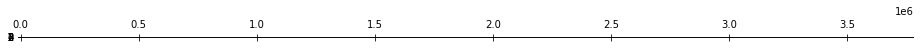

In [60]:
# Rolling window based features
window = 3

gp_monthly_sales = monthly_sales.groupby(['shop_id', 'item_id'])

# Actual value of last 3 months
for i in range(1, window + 1):
    monthly_sales['item_cnt_prev_month_' + str(i)] = gp_monthly_sales['item_cnt'].shift(i).fillna(0)

In [61]:
shifted = monthly_sales[[col for col in monthly_sales if col.startswith('item_cnt_prev_month')]]

# Min, max, mean and std of last 3 months
monthly_sales['item_cnt_prev_min'] = shifted.min(axis=1)
monthly_sales['item_cnt_prev_max'] = shifted.max(axis=1)
monthly_sales['item_cnt_prev_mean'] = shifted.mean(axis=1)
monthly_sales['item_cnt_prev_std'] = shifted.std(axis=1)

In [62]:
# Item trend with respect to last 3 months
monthly_sales['item_trend'] = monthly_sales['item_cnt'] - monthly_sales['item_cnt_prev_mean']

In [63]:
# Train set: Months 3 to 27 (drop 0 to 2 as we use 3-month window)
train_set = monthly_sales[(monthly_sales['date_block_num'] >= 3) & (monthly_sales['date_block_num'] < 28)].dropna().copy()
# Validation set: Months 28 to 32
validation_set = monthly_sales[(monthly_sales['date_block_num'] >= 28) & (monthly_sales['date_block_num'] < 33)].dropna().copy()
# Test set: Month 33 (last with available data)
test_set = monthly_sales[monthly_sales['date_block_num'] == 33].copy()

train_set_perc = 100 * train_set.shape[0] / monthly_sales.shape[0]
validation_set_perc = 100 * validation_set.shape[0] / monthly_sales.shape[0]
test_set_perc = 100 * test_set.shape[0] / monthly_sales.shape[0]

train_set_perc, validation_set_perc, test_set_perc

(73.51987594032484, 14.705429673512974, 2.940996021056718)

In [64]:
train_set.shape

(2780085, 24)

In [65]:
validation_set.shape

(556072, 24)

In [66]:
test_set.shape

(111211, 24)

In [67]:
# Shop mean encoding
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_next_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean = gp_shop_mean.reset_index()

# Item mean encoding
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_next_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean = gp_item_mean.reset_index()

# Shop-item mean encoding
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_next_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean = gp_shop_item_mean.reset_index()

# Year mean encoding
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_next_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean = gp_year_mean.reset_index()

# Month mean encoding
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_next_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean = gp_month_mean.reset_index()

# Add mean encodings to train and validation set
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')

validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [68]:
train_set.shape

(2780085, 29)

In [69]:
validation_set.shape

(556072, 29)

In [70]:
X_train = train_set.drop(['date_block_num', 'item_cnt_next_month'], axis=1)
y_train = train_set['item_cnt_next_month'].astype(int)

X_validation = validation_set.drop(['date_block_num', 'item_cnt_next_month'], axis=1)
y_validation = validation_set['item_cnt_next_month'].astype(int)

In [71]:
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [72]:
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((2780085, 27), (2780085,), (556072, 27), (556072,))

In [74]:
latest = validation_set[validation_set['date_block_num'] == 32]

X_test = pd.merge(test_set, latest, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])

X_test['year'] = 2015
X_test['month'] = 9

X_test = X_test.drop('item_cnt_next_month', axis=1)

X_test[int_features] = X_test[int_features].astype('int32')

X_test = X_test[X_train.columns]

X_test.shape

(111211, 27)

## Tree based models

### Catboost

In [75]:
# Specify indices for categorical features: shop_id, item_id, year and month
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation)
)

Learning rate set to 0.269924
0:	learn: 1.1077558	test: 1.1425111	best: 1.1425111 (0)	total: 2.26s	remaining: 18m 49s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 1.0670471
bestIteration = 12

Shrink model to first 13 iterations.


In [76]:
print('Model params:', catboost_model.get_params())

Model params: {'iterations': 500, 'depth': 4, 'loss_function': 'RMSE', 'od_wait': 25, 'od_type': 'Iter', 'random_seed': 0, 'verbose': 50, 'max_ctr_complexity': 4}


In [77]:
feature_scores = catboost_model.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_features))
feature_scores = pd.DataFrame({'Feature': X_train.dtypes.index, 'Score': feature_scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

feature_scores

,Feature,Score
24,shop_item_mean,43.241481
4,item_cnt,36.472285
19,item_cnt_prev_mean,5.026731
26,month_mean,4.078490
14,item_cnt_prev_month_1,2.251639
3,mean_item_price,2.028556
7,year,1.631775
18,item_cnt_prev_max,1.514580
2,item_price,1.447484
16,item_cnt_prev_month_3,0.637018


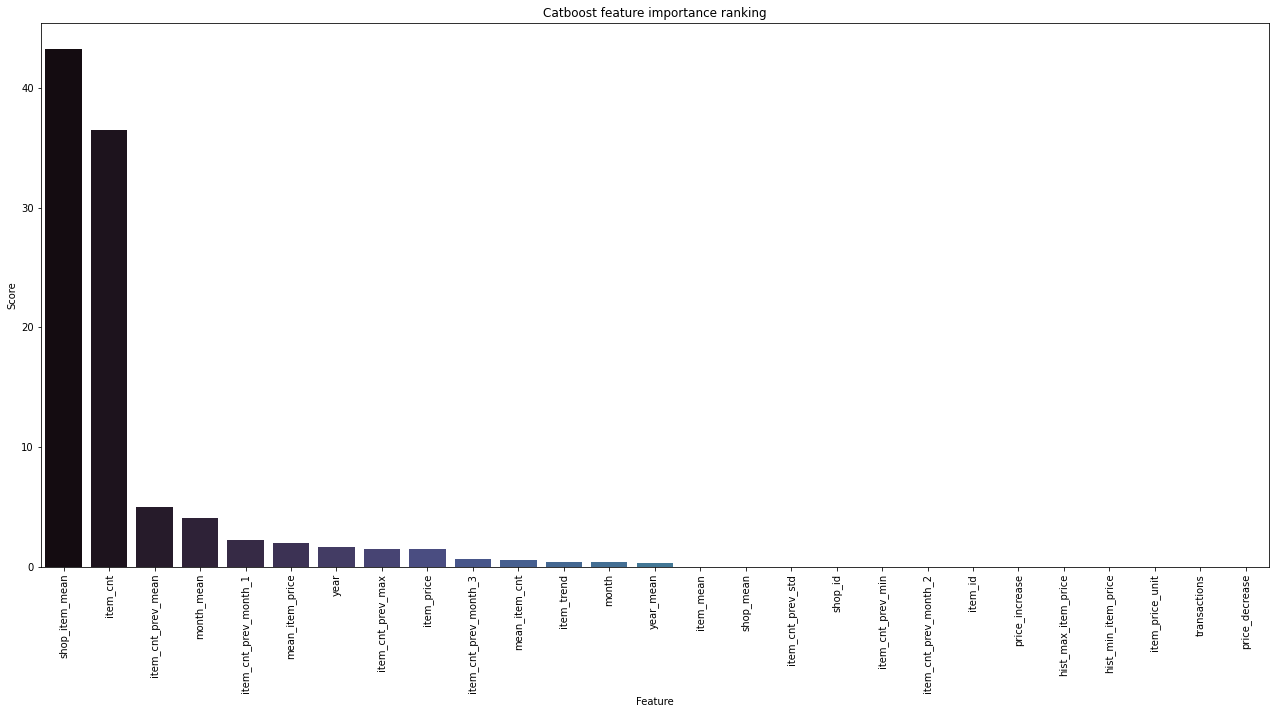

In [78]:
fig, ax = plt.subplots(figsize=(22, 10))
sns.barplot(x="Feature", y="Score", data=feature_scores, ax=ax, palette='mako').set_title('Catboost feature importance ranking')
ax.tick_params(axis='x', rotation=90)

In [79]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

print('Train rmse:', np.sqrt(mean_squared_error(y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_validation, catboost_val_pred)))

Train rmse: 0.9006610610690245
Validation rmse: 1.0670470996498544


## Submission

We are now ready to submit our predictions. To avoid repeating the training with the whole dataset, we will abuse the data and use the linear regression coefficients for the first 33 months instead of the first 34.

We finally generate the csv file ready for submission.

In [84]:
X_test['item_cnt_next_month'] = catboost_test_pred

In [86]:
def generate_submission_file(data, pred_field, filename='submission.csv'):
    predictions = pd.merge(test, data, on=['shop_id', 'item_id'], how='left').fillna(0)

    output = pd.DataFrame({'ID': predictions['ID'], 'item_cnt_month': predictions[pred_field]})
    output.to_csv('predictions/' + filename, index=False)
    print("Submission successfully saved!")

In [87]:
generate_submission_file(X_test, 'item_cnt_next_month')

Submission successfully saved!
